In [ ]:
# import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# list of companies
companies = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META']

In [ ]:
revenue_data = []
for company in companies:
    stock = yf.Ticker(company)
    income_statement = stock.financials
    if not income_statement.empty:
        latest_revenue = income_statement.loc['Total Revenue'].iloc[0]
        revenue_data.append({'symbol': company, 'revenue': latest_revenue})

In [ ]:
# Check the structure of revenue_data before sorting
print("Revenue Data: ", revenue_data)

Revenue Data:  [{'symbol': 'AAPL', 'revenue': 383285000000.0}, {'symbol': 'MSFT', 'revenue': 245122000000.0}, {'symbol': 'GOOGL', 'revenue': 307394000000.0}, {'symbol': 'AMZN', 'revenue': 574785000000.0}, {'symbol': 'TSLA', 'revenue': 96773000000.0}, {'symbol': 'META', 'revenue': 134902000000.0}]


In [ ]:
# Sort companies by revenue and get the top 3
if revenue_data:
    revenue_df = pd.DataFrame(revenue_data).sort_values(by='revenue', ascending=False).head(3)
    print(revenue_df)
else:
    print("No valid revenue data to sort.")

  symbol       revenue
3   AMZN  5.747850e+11
0   AAPL  3.832850e+11
2  GOOGL  3.073940e+11


In [ ]:
# use the top 3 companies for further analysis
top_3 = revenue_df['symbol'].tolist()

In [ ]:
# fetch stock data for top 3 companies using yfinance
stock_data = yf.download(top_3, start='2020-01-01', end='2024-01-01')['Adj Close']
stock_data.head()

[*********************100%***********************]  3 of 3 completed


Ticker,AAPL,AMZN,GOOGL
Date,,,
2020-01-02 00:00:00+00:00,72.876091,94.900497,68.264961
2020-01-03 00:00:00+00:00,72.167610,93.748497,67.907845
2020-01-06 00:00:00+00:00,72.742661,95.143997,69.717865
2020-01-07 00:00:00+00:00,72.400536,95.343002,69.583206
2020-01-08 00:00:00+00:00,73.565201,94.598503,70.078476


In [ ]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2020-01-02 00:00:00+00:00 to 2023-12-29 00:00:00+00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1006 non-null   float64
 1   AMZN    1006 non-null   float64
 2   GOOGL   1006 non-null   float64
dtypes: float64(3)
memory usage: 31.4 KB


In [ ]:
# Ensure stock_data is a DataFrame with DateTimeIndex
stock_data.index = pd.to_datetime(stock_data.index)  # Convert index to datetime if it isn't already

# Set the frequency of the index (daily frequency in this case)
stock_data = stock_data.asfreq('D')

In [ ]:
stock_data.isnull().sum()

,0
Ticker,
AAPL,452
AMZN,452
GOOGL,452


In [ ]:
#fill missing values
stock_data = stock_data.interpolate(method='linear')
stock_data.head()

Ticker,AAPL,AMZN,GOOGL
Date,,,
2020-01-02 00:00:00+00:00,72.876091,94.900497,68.264961
2020-01-03 00:00:00+00:00,72.167610,93.748497,67.907845
2020-01-04 00:00:00+00:00,72.359294,94.213664,68.511185
2020-01-05 00:00:00+00:00,72.550977,94.678830,69.114525
2020-01-06 00:00:00+00:00,72.742661,95.143997,69.717865


In [ ]:
# summary statistics
stock_data.describe()

Ticker,AAPL,AMZN,GOOGL
count,1458.000000,1458.000000,1458.000000
mean,138.830607,137.092855,107.548671
std,33.572167,27.489227,25.002562
min,54.569733,81.820000,52.576313
25%,121.305288,113.782499,87.828150
50%,143.724930,140.511673,109.481159
75%,164.009815,161.094374,129.928268
max,197.361084,186.570496,149.468399


* AAPL has the highest average price at $138.86.

* AAPL has the highest volatility (std = 33.58).This suggests that AAPL had larger price swings compared to the other two stocks during this period.

* AAPL has the largest range between the minimum and maximum prices, which might indicate periods of significant growth or volatility.

* AAPL had a more significant price increase, as its 75th percentile is much higher compared to the median.

* AMZN appears to have more stable growth, with its price distribution more evenly spread.

* GOOGL had the lowest price range of the three, indicating more steady, less volatile performance.





**Time Series Plot**

In [ ]:
# calculate 30-day moving averages
stock_data['AAPL_MA'] = stock_data['AAPL'].rolling(window=30).mean()
stock_data['AMZN_MA'] = stock_data['AMZN'].rolling(window=30).mean()
stock_data['GOOGL_MA'] = stock_data['GOOGL'].rolling(window=30).mean()

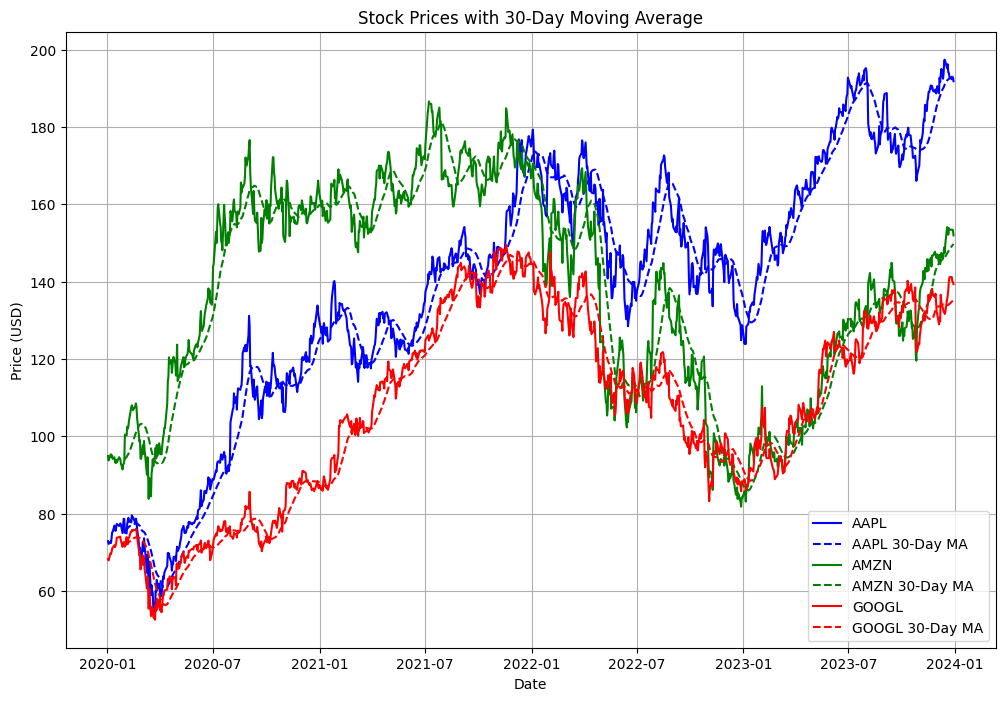

In [ ]:
# plotting Time Series for each stock with 30-day Moving Average
plt.figure(figsize=(12, 8))
plt.plot(stock_data.index, stock_data['AAPL'], label='AAPL', color='blue')
plt.plot(stock_data.index, stock_data['AAPL_MA'], label='AAPL 30-Day MA', linestyle='--', color='blue')

plt.plot(stock_data.index, stock_data['AMZN'], label='AMZN', color='green')
plt.plot(stock_data.index, stock_data['AMZN_MA'], label='AMZN 30-Day MA', linestyle='--', color='green')

plt.plot(stock_data.index, stock_data['GOOGL'], label='GOOGL', color='red')
plt.plot(stock_data.index, stock_data['GOOGL_MA'], label='GOOGL 30-Day MA', linestyle='--', color='red')

plt.title('Stock Prices with 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

* AAPL shows significant fluctuations, with upward and downward trends over time.

* AMZN shows similar fluctuations but with less volatility compared to AAPL.

* GOOGL shows a steadier trend with fewer extreme movements.

**Box plot**

<Figure size 1000x600 with 0 Axes>

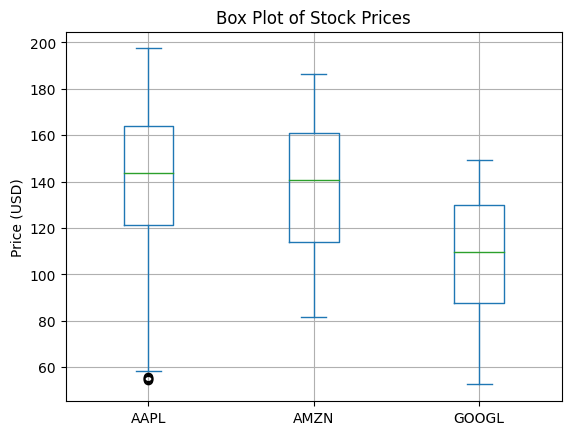

In [ ]:
# boxplot of stock prices
plt.figure(figsize=(10, 6))
stock_data[['AAPL', 'AMZN', 'GOOGL']].plot(kind='box')
plt.title('Box Plot of Stock Prices')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()

**Histogram Plot**

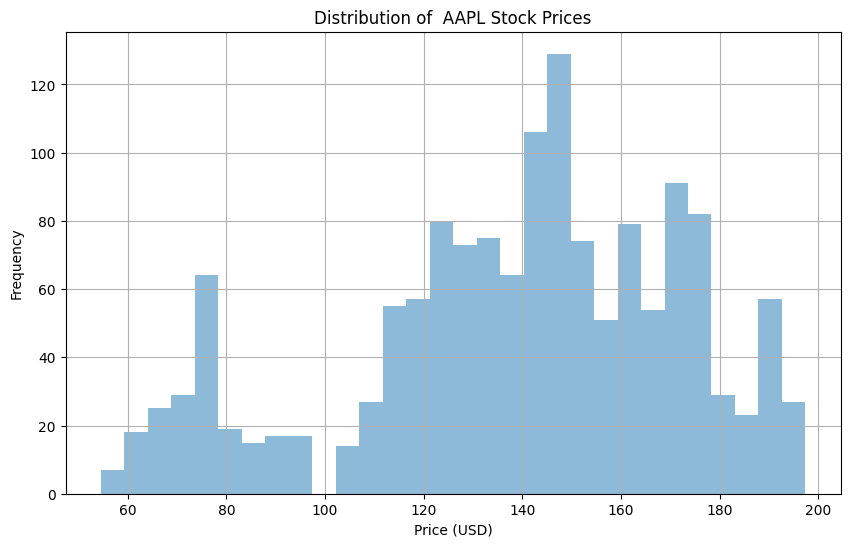

In [ ]:
# distribution of  AAPL plot
stock_data['AAPL'].plot(kind='hist', alpha=0.5, bins=30, figsize=(10, 6))
plt.title('Distribution of  AAPL Stock Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

* The distribution is slightly left-skewed, meaning there were more frequent dips in price, but its price tends to hover around a higher mean.
* The distribution has fat tails, suggesting that extreme values (both high and low) occur more frequently than in a normal distribution.

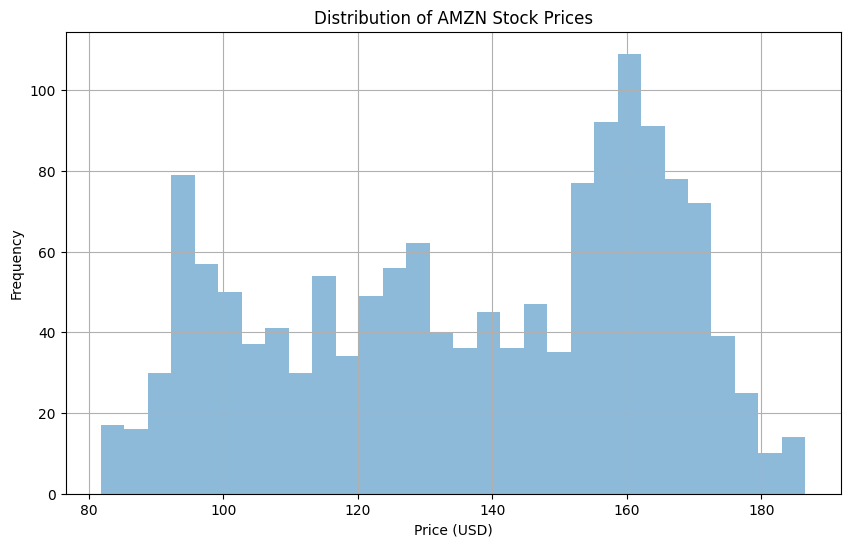

In [ ]:
# distribution of AMZN plot
stock_data['AMZN'].plot(kind='hist', alpha=0.5, bins=30, figsize=(10, 6))
plt.title('Distribution of AMZN Stock Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

* The distribution of AMZN is close to normal, with the mean and median stock prices aligning fairly well.
* AMZN shows a symmetric distribution, indicating balanced growth and risk.

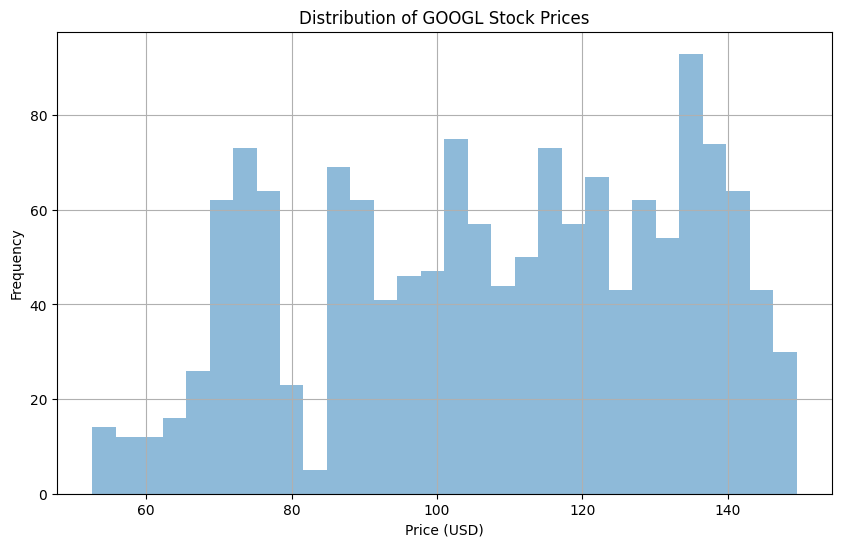

In [ ]:
# distribution of GOOGL plot
stock_data['GOOGL'].plot(kind='hist', alpha=0.5, bins=30, figsize=(10, 6))
plt.title('Distribution of GOOGL Stock Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

* GOOGL's distribution is more compact and peaks sharply around its mean, indicating less volatility.
* The right tail is slightly extended, meaning that higher stock prices were more common than lower dips.

**Correlation Heatmap**

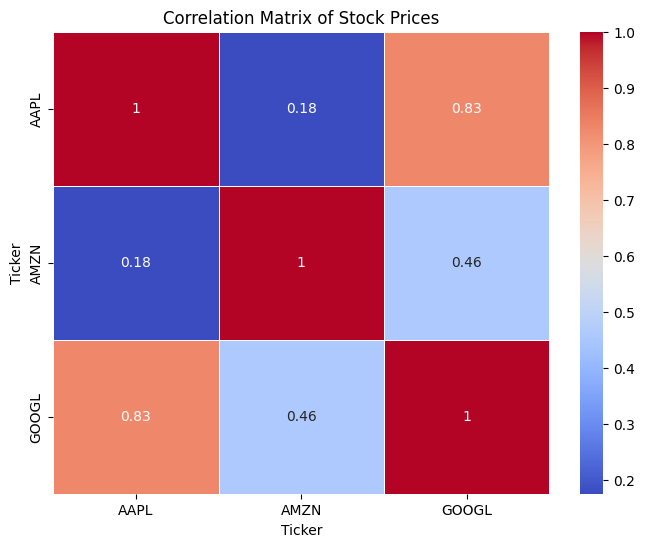

In [ ]:
# correlation heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = stock_data[['AAPL', 'AMZN', 'GOOGL']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Stock Prices')
plt.show()

* AAPL and GOOGL have a strong positive correlation of 0.83. This suggests that their stock prices move in the same direction most of the time. When one increases, the other tends to increase as well, and vice versa.

* AMZN and GOOGL have a moderate positive correlation of 0.46. While still positively correlated, their relationship is weaker than that of AAPL and GOOGL. This implies that while these two stocks may move in the same direction, it is not as consistent.

* AAPL and AMZN show a weak positive correlation of 0.17 meaning that their stock prices do not move together frequently. When one stock rises or falls, the other is less likely to follow the same pattern.

**Decompose the Time Series**

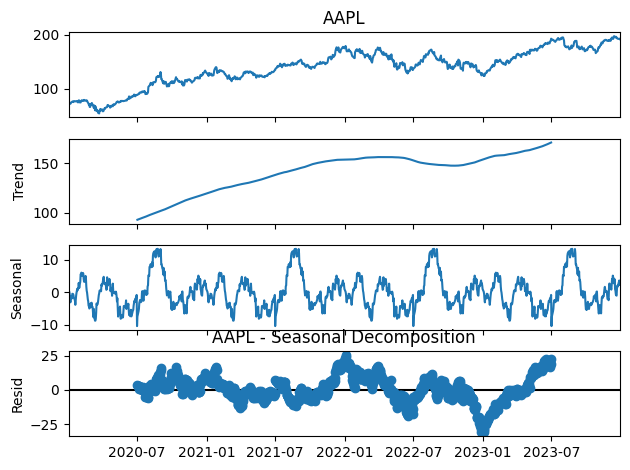

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

#seasonal-Trend Decomposition decomposes the time series into trend, seasonality, and residual (noise) components to identify patterns that might affect future prices.
# decompose the time series for each stock
result_aapl = seasonal_decompose(stock_data['AAPL'], model='additive', period=365)
result_amzn = seasonal_decompose(stock_data['AMZN'], model='additive', period=365)
result_googl = seasonal_decompose(stock_data['GOOGL'], model='additive', period=365)

# plot the decomposition for AAPL
result_aapl.plot()
plt.title('AAPL - Seasonal Decomposition')
plt.show()


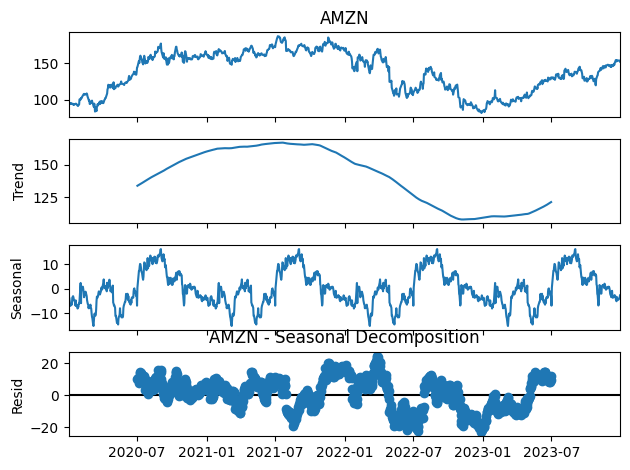

In [ ]:
# plot the decomposition for AMZN
result_amzn.plot()
plt.title('AMZN - Seasonal Decomposition')
plt.show()

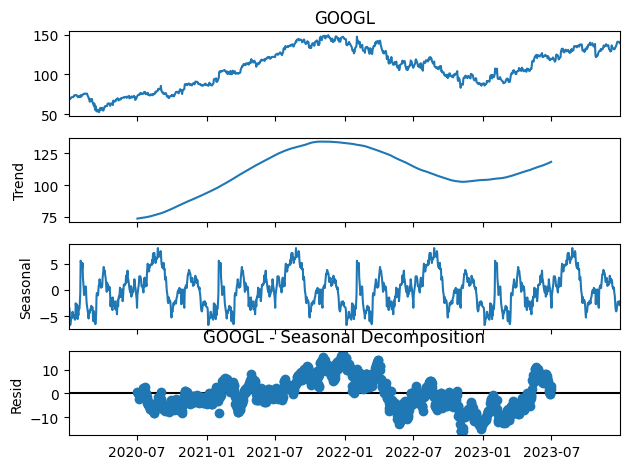

In [ ]:
# plot the decomposition for GOOGL
result_googl.plot()
plt.title('GOOGL - Seasonal Decomposition')
plt.show()

* Apple (AAPL) stands out as the most stable and resilient stock, with consistent upward growth and less impact from external factors. It also has predictable seasonal patterns, which are likely linked to product launches and holiday demand.
* Amazon (AMZN) shows the most pronounced seasonal variability, reflecting its e-commerce focus, but also has the most volatile trend and residuals, suggesting it is more sensitive to market fluctuations and external factors.
* Google (GOOGL) shares a similar overall pattern to AMZN, with a peak in 2021 and a downturn in 2022, followed by recovery in 2023. Google also has significant seasonal patterns but shows greater residual volatility, likely reflecting the company’s dependence on digital advertising and tech industry cycles.
* Apple's stock is generally seen as a safer, long-term investment, while Amazon and Google, despite being strong companies, may be viewed as more volatile in the short term but offer opportunities for strategic investments based on seasonal patterns and recovery trends.

**Lag Features**

They create columns that shift stock prices by a certain number of days to capture dependencies in the stock data. This helps the model learn from previous values.

In [ ]:
# create lag features of 1-day lag and 7-day lag
stock_data['AAPL_Lag1'] = stock_data['AAPL'].shift(1)
stock_data['AAPL_Lag7'] = stock_data['AAPL'].shift(7)

stock_data['AMZN_Lag1'] = stock_data['AMZN'].shift(1)
stock_data['AMZN_Lag7'] = stock_data['AMZN'].shift(7)

stock_data['GOOGL_Lag1'] = stock_data['GOOGL'].shift(1)
stock_data['GOOGL_Lag7'] = stock_data['GOOGL'].shift(7)

# Drop rows with NaN values caused by the lag shift
stock_data.dropna(inplace=True)


In [ ]:
print(stock_data.info())
stock_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1429 entries, 2020-01-31 00:00:00+00:00 to 2023-12-29 00:00:00+00:00
Freq: D
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   AAPL        1429 non-null   float64
 1   AMZN        1429 non-null   float64
 2   GOOGL       1429 non-null   float64
 3   AAPL_MA     1429 non-null   float64
 4   AMZN_MA     1429 non-null   float64
 5   GOOGL_MA    1429 non-null   float64
 6   AAPL_Lag1   1429 non-null   float64
 7   AAPL_Lag7   1429 non-null   float64
 8   AMZN_Lag1   1429 non-null   float64
 9   AMZN_Lag7   1429 non-null   float64
 10  GOOGL_Lag1  1429 non-null   float64
 11  GOOGL_Lag7  1429 non-null   float64
dtypes: float64(12)
memory usage: 145.1 KB
None


Ticker,AAPL,AMZN,GOOGL,AAPL_MA,AMZN_MA,GOOGL_MA,AAPL_Lag1,AAPL_Lag7,AMZN_Lag1,AMZN_Lag7,GOOGL_Lag1,GOOGL_Lag7
Date,,,,,,,,,,,,
2020-01-31 00:00:00+00:00,75.098656,100.435997,71.462051,75.662151,94.077266,71.702827,78.582939,77.233879,93.533997,93.082001,72.532898,73.127426
2020-02-01 00:00:00+00:00,75.029912,100.360664,72.290332,75.733945,94.259271,71.837006,75.098656,76.476852,100.435997,92.527000,71.462051,72.554845
2020-02-02 00:00:00+00:00,74.961169,100.285332,73.118612,75.827063,94.477166,72.010699,75.029912,75.719826,100.360664,91.972000,72.290332,71.982264
2020-02-03 00:00:00+00:00,74.892426,100.209999,73.946892,75.911501,94.677044,72.191889,74.961169,74.962799,100.285332,91.417000,73.118612,71.409683
2020-02-04 00:00:00+00:00,77.364899,102.483498,72.091988,76.071965,94.937199,72.291138,74.892426,77.083435,100.209999,92.662498,73.946892,72.345863


**Augmented Dickey-Fuller (ADF) test to check for stationarity**

In [ ]:
from statsmodels.tsa.stattools import adfuller

# ADF test for AAPL
adf_result = adfuller(stock_data['AAPL'])
print(f'ADF Statistic for AAPL: {adf_result[0]}')
print(f'p-value for AAPL: {adf_result[1]}')

# If p-value is less than 0.05, the data is stationary


ADF Statistic for AAPL: -1.480352110313981
p-value for AAPL: 0.543207515478252


- The p-value is greater than 0.05 which means the data is non-stationary.
- Time series models require data to be stationary, we can transform it using differencing.

In [ ]:
# differencing
stock_data['AAPL_Diff'] = stock_data['AAPL'].diff().dropna()

**ACF and PACF plots**

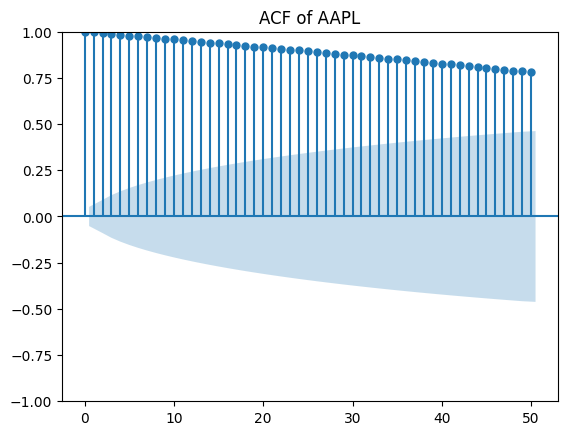

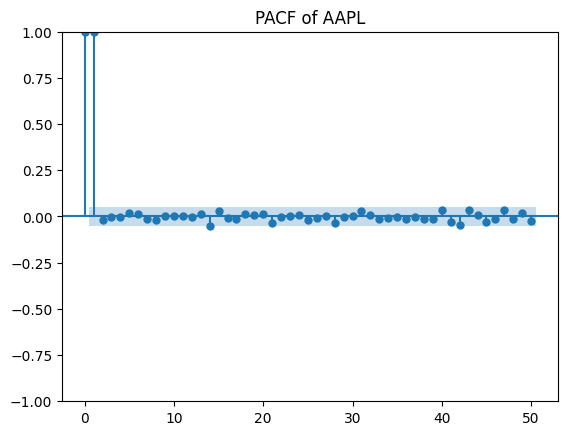

In [ ]:
# acf plot for AAPL
plot_acf(stock_data['AAPL'], lags=50)
plt.title('ACF of AAPL')
plt.show()

# pacf plot for AAPL
plot_pacf(stock_data['AAPL'], lags=50)
plt.title('PACF of AAPL')
plt.show()


**APPLE**

In [ ]:
# data for AAPL stock
aapl_data = stock_data['AAPL']

# split into train-test
train, test = train_test_split(aapl_data, train_size=0.8, shuffle=False)

print(f"Training set: {len(train)} samples")
print(f"Test set: {len(test)} samples")

Training set: 1143 samples
Test set: 286 samples


**Model 1: ARIMA (AutoRegressive Integrated Moving Average)**

In [ ]:
# build ARIMA model
aapl_arima_model = ARIMA(train, order=(5,1,2))  # (p,d,q) order for ARIMA
aapl_arima_model_fit = aapl_arima_model.fit()

# forecast for the test set
aapl_arima_forecast = aapl_arima_model_fit.forecast(steps=len(test))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
# evaluate ARIMA model
aapl_mae_arima = mean_absolute_error(test, aapl_arima_forecast)
aapl_rmse_arima = np.sqrt(mean_squared_error(test, aapl_arima_forecast))

print(f' AAPL ARIMA MAE: {aapl_mae_arima}')
print(f'AAPL ARIMA RMSE: {aapl_rmse_arima}')

 AAPL ARIMA MAE: 24.38651165895522
AAPL ARIMA RMSE: 26.54126654889242


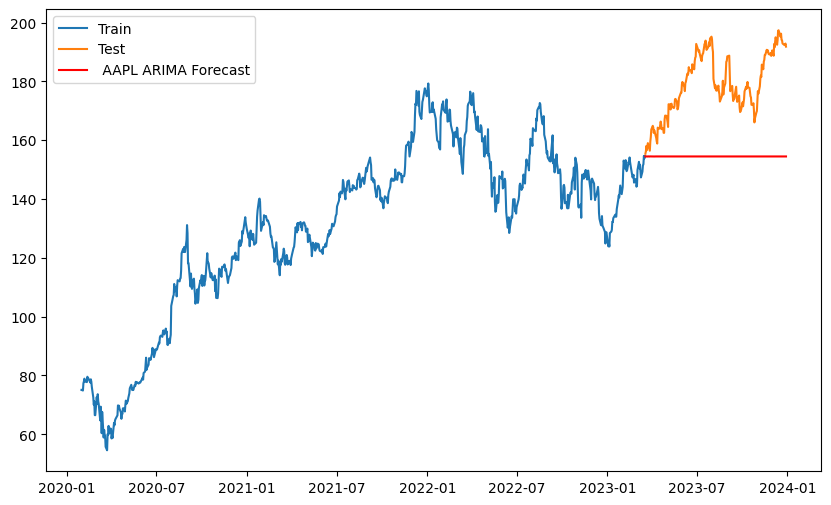

In [ ]:
# plot the forecast against the actual data
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, aapl_arima_forecast, label=' AAPL ARIMA Forecast', color='red')
plt.legend()
plt.show()

**Model 2: SARIMA (Seasonal Arima)**

In [ ]:
# fit SARIMA model
aapl_sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()

# forecast on the test data
aapl_sarima_forecast = aapl_sarima_model.forecast(steps=len(test))

In [ ]:
# evaluate SARIMA model
aapl_sarima_mae = mean_absolute_error(test, aapl_sarima_forecast)
aapl_sarima_rmse = np.sqrt(mean_squared_error(test, aapl_sarima_forecast))

print(f'SARIMA MAE: {aapl_sarima_mae}')
print(f'SARIMA RMSE: {aapl_sarima_rmse}')

SARIMA MAE: 14.670591821113856
SARIMA RMSE: 16.791451059101018


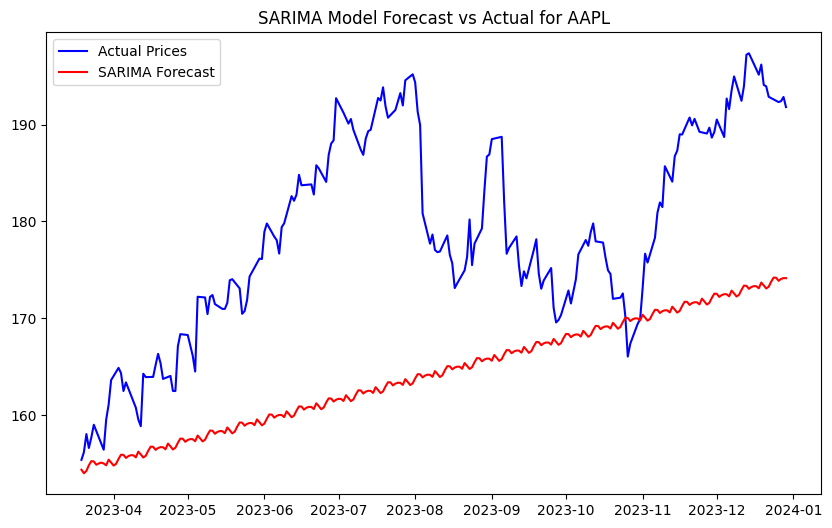

In [ ]:
# plot the forecast vs actual
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual Prices', color='blue')
plt.plot(test.index, aapl_sarima_forecast, label='SARIMA Forecast', color='red')
plt.title('SARIMA Model Forecast vs Actual for AAPL')
plt.legend()
plt.show()

**Model 3:LSTM**

In [ ]:
# scaling the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

# prepare data
def create_lstm_dataset(aapl_data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(aapl_data)):
        X.append(aapl_data[i-time_steps:i, 0])
        y.append(aapl_data[i, 0])
    return np.array(X), np.array(y)

# creating LSTM input/output
time_steps = 60
X_train, y_train = create_lstm_dataset(train_scaled, time_steps)
X_test, y_test = create_lstm_dataset(test_scaled, time_steps)

# reshaping the data to fit LSTM (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
#build the LSTM model
aapl_lstm_model = Sequential()
aapl_lstm_model.add(Input(shape=(X_train.shape[1], 1)))
aapl_lstm_model.add(LSTM(units=50, return_sequences=True))
aapl_lstm_model.add(LSTM(units=50))
aapl_lstm_model.add(Dense(1))

aapl_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# fit the model
aapl_lstm_model.fit(X_train, y_train, epochs=20, batch_size=32)


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.1779
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0045
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0022
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0019
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0018
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0016
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0017
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0016
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0014
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0014
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0013
Epoch 12/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0014
Epoch 13/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0014
Epoch 14/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0014
Epoch 15/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0012
Epoc

In [ ]:
# predicting the test set
aapl_lstm_pred_scaled = aapl_lstm_model.predict(X_test)

# inverse scaling to get the original prices back
aapl_lstm_pred = scaler.inverse_transform(aapl_lstm_pred_scaled)

# evaluate the LSTM model
aapl_lstm_mae = mean_absolute_error(test[time_steps:], aapl_lstm_pred)
aapl_lstm_rmse = np.sqrt(mean_squared_error(test[time_steps:], aapl_lstm_pred))

print(f' AAPL LSTM MAE: {aapl_lstm_mae}')
print(f'AAPL LSTM RMSE: {aapl_lstm_rmse}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
 AAPL LSTM MAE: 3.7399299981671446
AAPL LSTM RMSE: 4.379626510885746


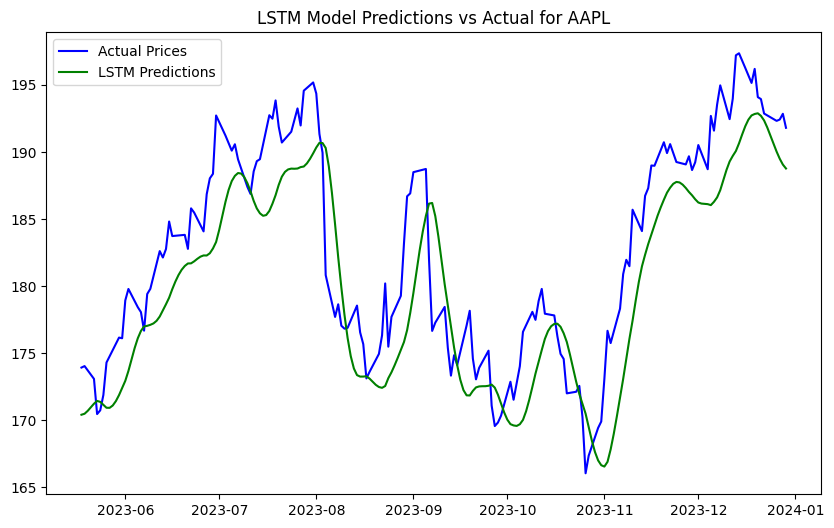

In [ ]:
# plot the LSTM predictions vs actual prices
plt.figure(figsize=(10, 6))
plt.plot(test.index[time_steps:], test[time_steps:], label='Actual Prices', color='blue')
plt.plot(test.index[time_steps:], aapl_lstm_pred, label='LSTM Predictions', color='green')
plt.title('LSTM Model Predictions vs Actual for AAPL')
plt.legend()
plt.show()

**AMAZON**

In [ ]:
# data for AMZN stock
amzn_data = stock_data['AMZN']

# split
train, test = train_test_split(amzn_data, train_size=0.8, shuffle=False)

print(f"Training set: {len(train)} samples")
print(f"Test set: {len(test)} samples")

Training set: 1143 samples
Test set: 286 samples


**Model 1: ARIMA**

In [ ]:
# build ARIMA model
amzn_arima_model = ARIMA(train, order=(5,1,2))  # (p,d,q) order for ARIMA
amzn_arima_model_fit = amzn_arima_model.fit()

# forecast for the test set
amzn_arima_forecast = amzn_arima_model_fit.forecast(steps=len(test))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
# evaluate ARIMA model
amzn_mae_arima = mean_absolute_error(test, amzn_arima_forecast)
amzn_rmse_arima = np.sqrt(mean_squared_error(test, amzn_arima_forecast))

print(f' AMZN ARIMA MAE: {amzn_mae_arima}')
print(f'AMZN ARIMA RMSE: {amzn_rmse_arima}')

 AMZN ARIMA MAE: 29.820909914387578
AMZN ARIMA RMSE: 33.42180484458337


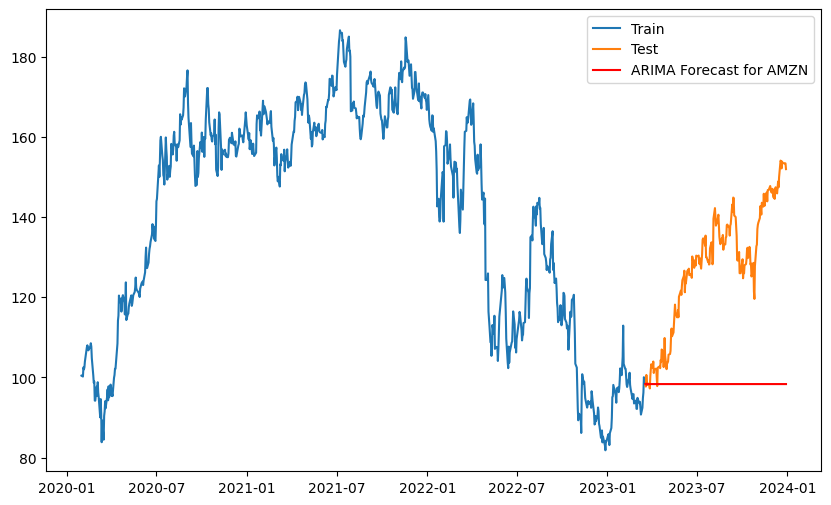

In [ ]:
# plot the forecast against the actual data
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, amzn_arima_forecast, label='ARIMA Forecast for AMZN', color='red')
plt.legend()
plt.show()

**Model 2: SARIMA**

In [ ]:
# fit SARIMA model
amzn_sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()

# forecast on the test data
amzn_sarima_forecast = amzn_sarima_model.forecast(steps=len(test))

In [ ]:
# evaluate SARIMA model
amzn_sarima_mae = mean_absolute_error(test, amzn_sarima_forecast)
amzn_sarima_rmse = np.sqrt(mean_squared_error(test, amzn_sarima_forecast))

print(f' AMZN SARIMA MAE: {amzn_sarima_mae}')
print(f'AMZN SARIMA RMSE: {amzn_sarima_rmse}')

 AMZN SARIMA MAE: 30.054888662920757
AMZN SARIMA RMSE: 33.68099583022784


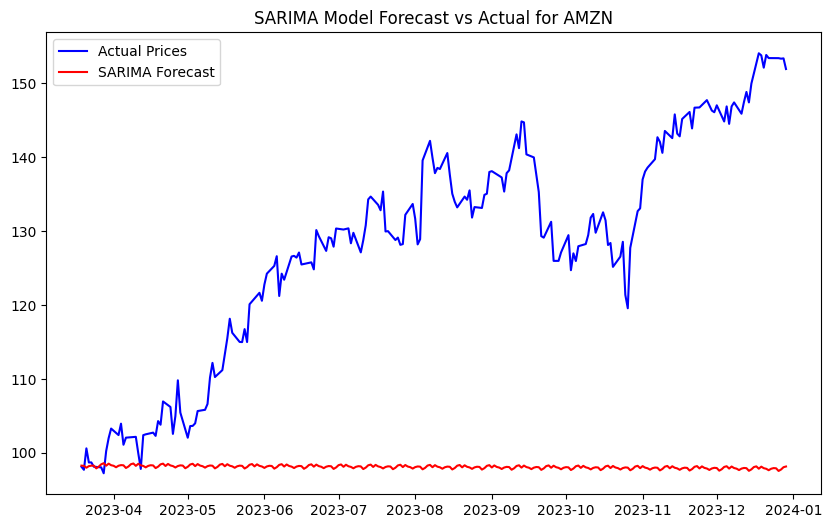

In [ ]:
# plot the forecast vs actual
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual Prices', color='blue')
plt.plot(test.index, amzn_sarima_forecast, label='SARIMA Forecast', color='red')
plt.title('SARIMA Model Forecast vs Actual for AMZN')
plt.legend()
plt.show()

**Model 3: LTSM**

In [ ]:
# scaling the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

# prepare data
def create_lstm_dataset(amzn_data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(amzn_data)):
        X.append(amzn_data[i-time_steps:i, 0])
        y.append(amzn_data[i, 0])
    return np.array(X), np.array(y)

# creating LSTM input/output
time_steps = 60
X_train, y_train = create_lstm_dataset(train_scaled, time_steps)
X_test, y_test = create_lstm_dataset(test_scaled, time_steps)

# reshaping the data to fit LSTM (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# build the LSTM model
amzn_lstm_model = Sequential()
amzn_lstm_model.add(Input(shape=(X_train.shape[1], 1)))
amzn_lstm_model.add(LSTM(units=50, return_sequences=True))
amzn_lstm_model.add(LSTM(units=50))
amzn_lstm_model.add(Dense(1))

amzn_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# fit the model
amzn_lstm_model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.1546
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0069
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0037
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0033
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0030
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0033
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0032
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0027
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0027
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0025
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0025
Epoch 12/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0025
Epoch 13/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0024
Epoch 14/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0022
Epoch 15/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0020
Epoc

In [ ]:
# predicting the test set
amzn_lstm_pred_scaled = amzn_lstm_model.predict(X_test)

# inverse scaling to get the original prices back
amzn_lstm_pred = scaler.inverse_transform(amzn_lstm_pred_scaled)

# evaluate the LSTM model
amzn_lstm_mae = mean_absolute_error(test[time_steps:], amzn_lstm_pred)
amzn_lstm_rmse = np.sqrt(mean_squared_error(test[time_steps:], amzn_lstm_pred))

print(f' AMZN LSTM MAE: {amzn_lstm_mae}')
print(f'AMZN LSTM RMSE: {amzn_lstm_rmse}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
 AMZN LSTM MAE: 2.189733584018583
AMZN LSTM RMSE: 2.897846349751224


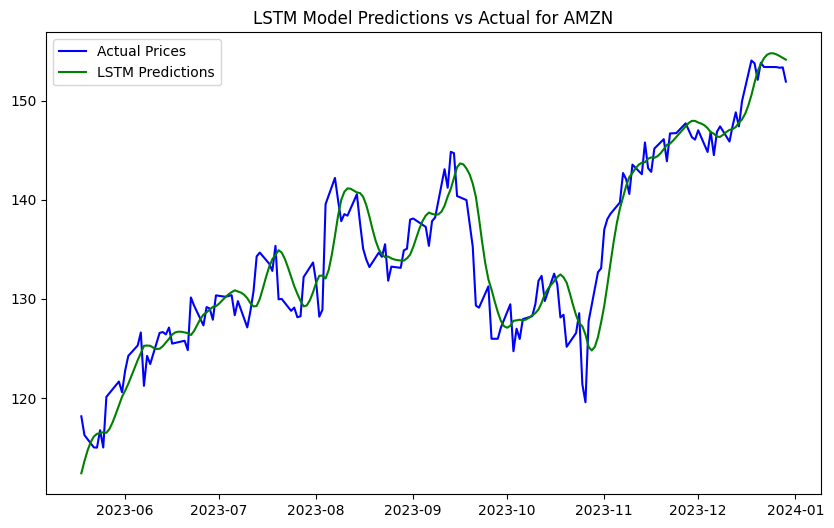

In [ ]:
# plot the LSTM predictions vs actual prices
plt.figure(figsize=(10, 6))
plt.plot(test.index[time_steps:], test[time_steps:], label='Actual Prices', color='blue')
plt.plot(test.index[time_steps:], amzn_lstm_pred, label='LSTM Predictions', color='green')
plt.title('LSTM Model Predictions vs Actual for AMZN')
plt.legend()
plt.show()

**GOOGL**

In [ ]:
# data for GOOGL stock
googl_data = stock_data['GOOGL']

# split
train, test = train_test_split(googl_data, train_size=0.8, shuffle=False)

print(f"Training set: {len(train)} samples")
print(f"Test set: {len(test)} samples")

Training set: 1143 samples
Test set: 286 samples


In [ ]:
# build ARIMA model
googl_arima_model = ARIMA(train, order=(5,1,2))  # (p,d,q) order for ARIMA
googl_arima_model_fit = googl_arima_model.fit()

# forecast for the test set
googl_arima_forecast = googl_arima_model_fit.forecast(steps=len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
# evaluate ARIMA model
googl_mae_arima = mean_absolute_error(test, googl_arima_forecast)
googl_rmse_arima = np.sqrt(mean_squared_error(test, googl_arima_forecast))

print(f'GOOGL ARIMA MAE: {googl_mae_arima}')
print(f'GOOGL ARIMA RMSE: {googl_rmse_arima}')

GOOGL ARIMA MAE: 24.685150077271192
GOOGL ARIMA RMSE: 27.112064429311026


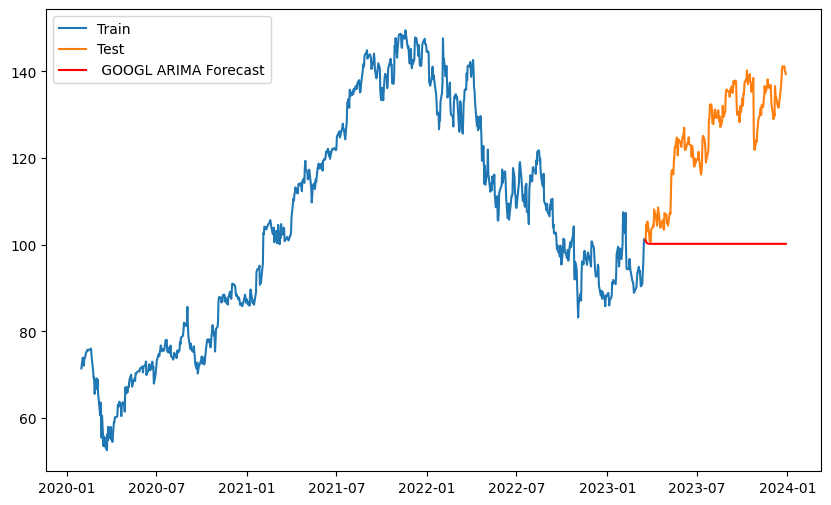

In [ ]:
# plot the forecast against the actual data
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, googl_arima_forecast, label=' GOOGL ARIMA Forecast', color='red')
plt.legend()
plt.show()

**Model 2: SARIMA**

In [ ]:
# fit SARIMA model
googl_sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()

# forecast on the test data
googl_sarima_forecast = googl_sarima_model.forecast(steps=len(test))

In [ ]:
# evaluate SARIMA model
googl_sarima_mae = mean_absolute_error(test, googl_sarima_forecast)
googl_sarima_rmse = np.sqrt(mean_squared_error(test, googl_sarima_forecast))

print(f' AMZN SARIMA MAE: {googl_sarima_mae}')
print(f'AMZN SARIMA RMSE: {googl_sarima_rmse}')

 AMZN SARIMA MAE: 20.19213475125006
AMZN SARIMA RMSE: 22.259355253882312


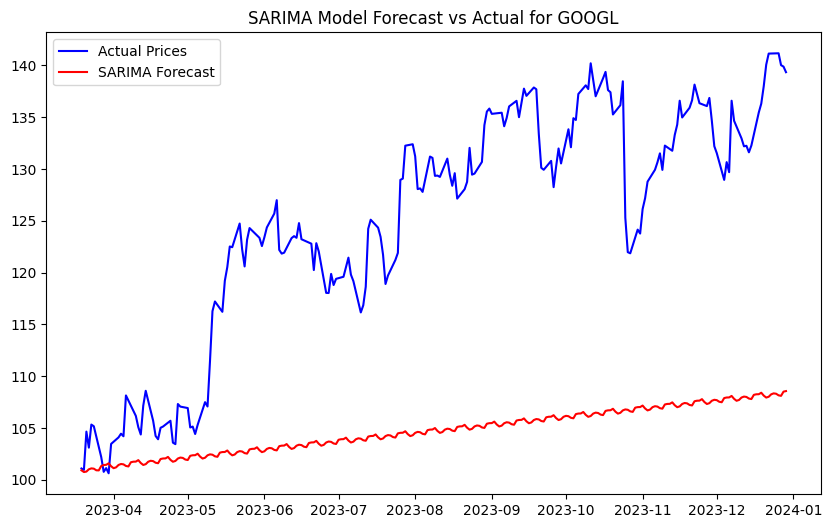

In [ ]:
# plot the forecast vs actual
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual Prices', color='blue')
plt.plot(test.index, googl_sarima_forecast, label='SARIMA Forecast', color='red')
plt.title('SARIMA Model Forecast vs Actual for GOOGL')
plt.legend()
plt.show()

**Model 3: LSTM**

In [ ]:
# scaling the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

# prepare data
def create_lstm_dataset(googl_data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(googl_data)):
        X.append(googl_data[i-time_steps:i, 0])
        y.append(googl_data[i, 0])
    return np.array(X), np.array(y)

# creating LSTM input/output
time_steps = 60
X_train, y_train = create_lstm_dataset(train_scaled, time_steps)
X_test, y_test = create_lstm_dataset(test_scaled, time_steps)

# reshaping the data to fit LSTM (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# build the LSTM model
googl_lstm_model = Sequential()
googl_lstm_model.add(Input(shape=(X_train.shape[1], 1)))  # Use Input layer to define input shape
googl_lstm_model.add(LSTM(units=50, return_sequences=True))
googl_lstm_model.add(LSTM(units=50))
googl_lstm_model.add(Dense(1))  # Output layer for predicting the stock price

googl_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# fit the model
googl_lstm_model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.1167
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0042
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0016
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0015
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0016
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0014
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0013
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0013
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0013
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0014
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0011
Epoch 12/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0012
Epoch 13/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0011
Epoch 14/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0011
Epoch 15/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0013
Epoc

In [ ]:
# predicting the test set
googl_lstm_pred_scaled = googl_lstm_model.predict(X_test)

# inverse scaling to get the original prices back
googl_lstm_pred = scaler.inverse_transform(googl_lstm_pred_scaled)

# evaluate the LSTM model
googl_lstm_mae = mean_absolute_error(test[time_steps:], googl_lstm_pred)
googl_lstm_rmse = np.sqrt(mean_squared_error(test[time_steps:], googl_lstm_pred))

print(f' GOOGL LSTM MAE: {googl_lstm_mae}')
print(f'GOOGL LSTM RMSE: {googl_lstm_rmse}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
 GOOGL LSTM MAE: 2.5341121876134283
GOOGL LSTM RMSE: 3.367856521167631


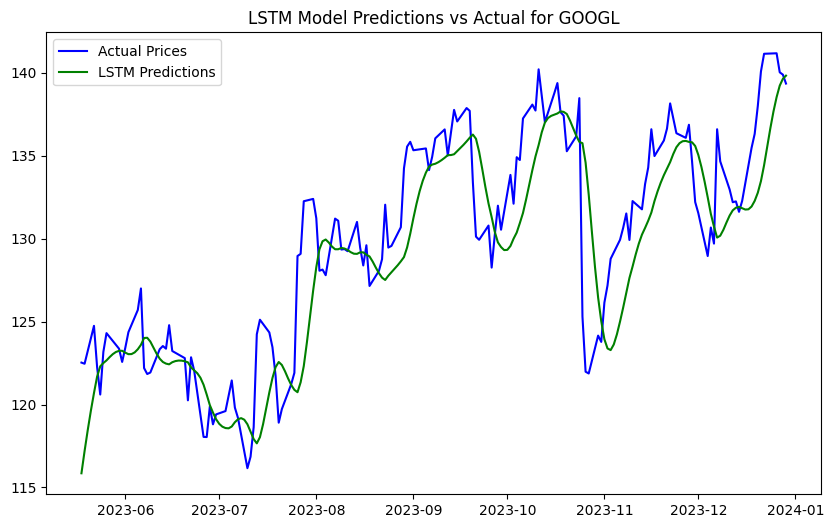

In [ ]:
# plot the LSTM predictions vs actual prices
plt.figure(figsize=(10, 6))
plt.plot(test.index[time_steps:], test[time_steps:], label='Actual Prices', color='blue')
plt.plot(test.index[time_steps:], googl_lstm_pred, label='LSTM Predictions', color='green')
plt.title('LSTM Model Predictions vs Actual for GOOGL')
plt.legend()
plt.show()

In [ ]:
#define a function to extract relevant model performance metrics (MAE, RMSE) for summarization
def extract_performance_metrics():
    metrics = {
        'AAPL': {'ARIMA': {}, 'SARIMA': {}, 'LSTM': {}},
        'AMZN': {'ARIMA': {}, 'SARIMA': {}, 'LSTM': {}},
        'GOOGL': {'ARIMA': {}, 'SARIMA': {}, 'LSTM': {}}
    }

    try:
        # AAPL Metrics
        metrics['AAPL']['ARIMA']['MAE'] = aapl_mae_arima
        metrics['AAPL']['ARIMA']['RMSE'] = aapl_rmse_arima
        metrics['AAPL']['SARIMA']['MAE'] = aapl_sarima_mae
        metrics['AAPL']['SARIMA']['RMSE'] = aapl_sarima_rmse
        metrics['AAPL']['LSTM']['MAE'] = aapl_lstm_mae
        metrics['AAPL']['LSTM']['RMSE'] = aapl_lstm_rmse

        # AMZN Metrics
        metrics['AMZN']['ARIMA']['MAE'] = amzn_mae_arima
        metrics['AMZN']['ARIMA']['RMSE'] = amzn_rmse_arima
        metrics['AMZN']['SARIMA']['MAE'] = amzn_sarima_mae
        metrics['AMZN']['SARIMA']['RMSE'] = amzn_sarima_rmse
        metrics['AMZN']['LSTM']['MAE'] = amzn_lstm_mae
        metrics['AMZN']['LSTM']['RMSE'] = amzn_lstm_rmse

        # GOOGL Metrics
        metrics['GOOGL']['ARIMA']['MAE'] = googl_mae_arima
        metrics['GOOGL']['ARIMA']['RMSE'] = googl_rmse_arima
        metrics['GOOGL']['SARIMA']['MAE'] = googl_sarima_mae
        metrics['GOOGL']['SARIMA']['RMSE'] = googl_sarima_rmse
        metrics['GOOGL']['LSTM']['MAE'] = googl_lstm_mae
        metrics['GOOGL']['LSTM']['RMSE'] = googl_lstm_rmse
    except NameError:
        print("Some metric variables are not defined in the notebook.")

    return metrics

# Execute the function to extract and summarize the metrics
performance_metrics = extract_performance_metrics()
performance_metrics


{'AAPL': {'ARIMA': {'MAE': 24.38651165895522, 'RMSE': 26.54126654889242},
  'SARIMA': {'MAE': 14.670591821113856, 'RMSE': 16.791451059101018},
  'LSTM': {'MAE': 3.7399299981671446, 'RMSE': 4.379626510885746}},
 'AMZN': {'ARIMA': {'MAE': 29.820909914387578, 'RMSE': 33.42180484458337},
  'SARIMA': {'MAE': 30.054888662920757, 'RMSE': 33.68099583022784},
  'LSTM': {'MAE': 2.189733584018583, 'RMSE': 2.897846349751224}},
 'GOOGL': {'ARIMA': {'MAE': 24.685150077271192, 'RMSE': 27.112064429311026},
  'SARIMA': {'MAE': 20.19213475125006, 'RMSE': 22.259355253882312},
  'LSTM': {'MAE': 2.5341121876134283, 'RMSE': 3.367856521167631}}}

In [ ]:
#flatten the dict and convert to df
flattened_data = []
for ticker, models in performance_metrics.items():
    for model, metrics in models.items():
        flattened_data.append({
            'Ticker': ticker,
            'Model': model,
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE']
        })

#create df
df_flat = pd.DataFrame(flattened_data)
df_flat

,Ticker,Model,MAE,RMSE
0,AAPL,ARIMA,24.386512,26.541267
1,AAPL,SARIMA,14.670592,16.791451
2,AAPL,LSTM,3.739930,4.379627
3,AMZN,ARIMA,29.820910,33.421805
4,AMZN,SARIMA,30.054889,33.680996
5,AMZN,LSTM,2.189734,2.897846
6,GOOGL,ARIMA,24.685150,27.112064
7,GOOGL,SARIMA,20.192135,22.259355
8,GOOGL,LSTM,2.534112,3.367857


LSTM was the best performing model with the lowest MAE and RSME scores across all stocks indicating it provides the most accurate predictions. This makes it more suitable for forecasting stock prices.
